
# Credit Card Fraud Detection — SVM & CNN (Imbalanced Learning)



## imports and enablers

In [ ]:

# Core
import os, math, json, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, precision_recall_curve, average_precision_score,
                             confusion_matrix, precision_score, recall_score, f1_score, make_scorer)
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# Imbalance helpers (optional SMOTE)
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

RESULTS_DIR = "/Users/chandramukherjee/azure/python_projects/results"
#I used my husband's MacBook pro for running these models hence the path shows username like that

os.makedirs(RESULTS_DIR, exist_ok=True)


/Users/chandramukherjee/azure/python_projects/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/chandramukherjee/azure/python_projects/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/chandramukherjee/azure/python_projects/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at te

## Load data

In [ ]:

CSV_PATH = "/Users/chandramukherjee/azure/python_projects/creditcard.csv"

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

Dataset shape: (284807, 31)

Data types:
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class   

/var/folders/2k/gjyzbrs523gfs9ppyrslgz0h0000gn/T/ipykernel_89835/2377930425.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")


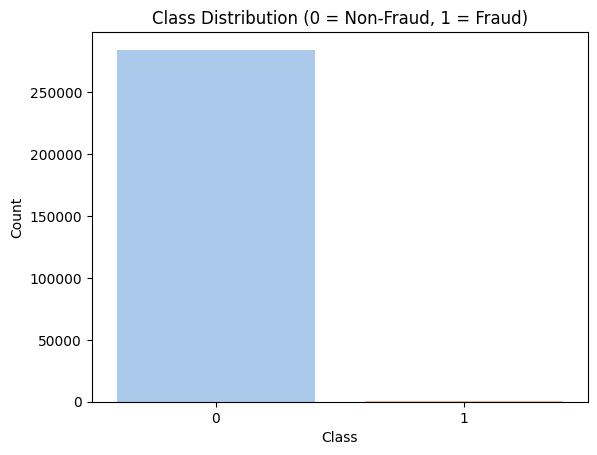

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

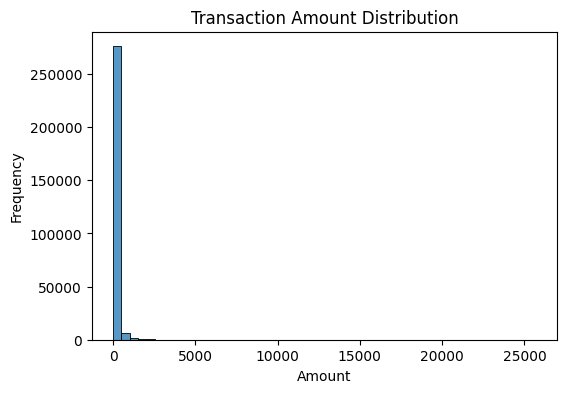

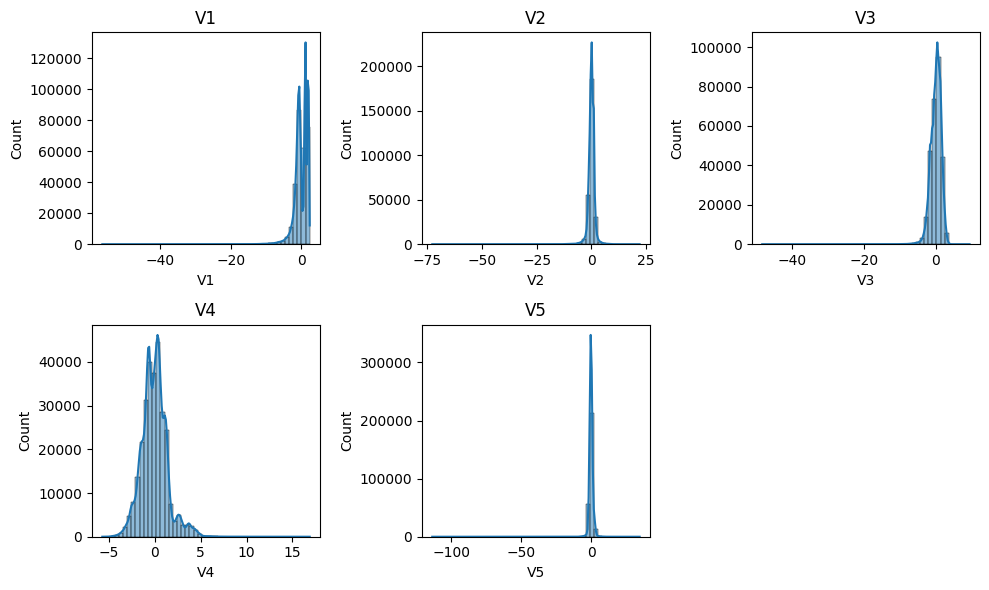

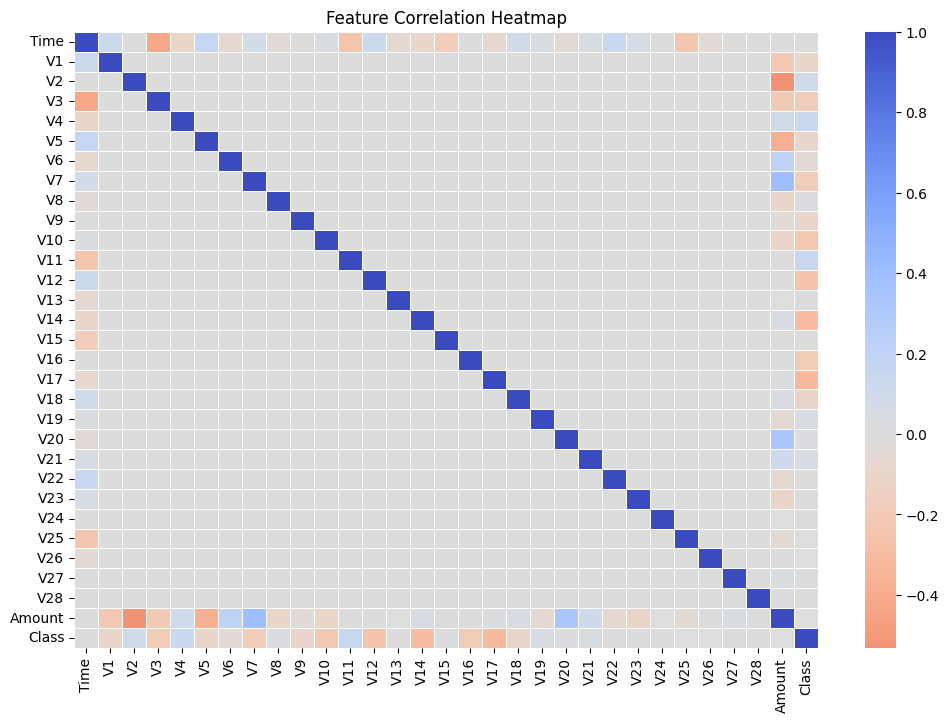

In [3]:

# Basic info
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Class distribution
class_counts = df['Class'].value_counts()
class_percent = class_counts / len(df) * 100
print("\nClass distribution:\n", pd.DataFrame({'Count': class_counts, 'Percentage': class_percent}))

# Bar plot for imbalance
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Summary stats for numerical features
print(df.describe())

# Check amount distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, kde=False)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Plot a few PCA components to inspect distribution
plt.figure(figsize=(10,6))
for i, col in enumerate(['V1', 'V2', 'V3', 'V4', 'V5']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


#heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm_r", center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Class balance

,count,percent
Class,,
0,284315,99.8273
1,492,0.1727


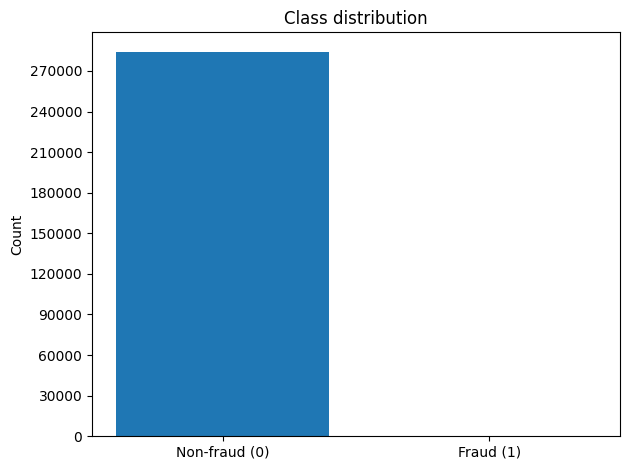

In [4]:

counts = df['Class'].value_counts().sort_index()
perc = counts / counts.sum() * 100
display(pd.DataFrame({'count': counts, 'percent': perc.round(4)}))

# Bar plot
plt.figure()
plt.bar(['Non-fraud (0)', 'Fraud (1)'], counts.values)
plt.title('Class distribution')
plt.ylabel('Count')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "class_distribution.png"), dpi=150)
plt.show()


## Helpers: metrics & reporting

In [6]:

def evaluate_metrics(y_true, y_pred, positive_label=1):
    return {
        "precision": precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
        "recall": recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0),
    }

def summarize_results(rows, out_csv):
    df_res = pd.DataFrame(rows)
    # Per-model mean
    summary = df_res.groupby("model")[["precision","recall","f1"]].mean().rename(columns={
        "precision":"Mean Precision (Fraud=1)",
        "recall":"Mean Recall (Fraud=1)",
        "f1":"Mean F1 (Fraud=1)"
    }).round(4).reset_index()
    display(summary)
    summary.to_csv(os.path.join(RESULTS_DIR, out_csv), index=False)
    return df_res, summary


## Model 1: SVM (pipeline + StandardScaler + class_weight + GridSearchCV)

In [7]:

X = df.drop(columns=["Class"]).values
y = df["Class"].values

# class weights for imbalance
classes = np.unique(y)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(c): w for c, w in zip(classes, cw)}
class_weight_dict


{0: 0.5008652375006595, 1: 289.4380081300813}

In [ ]:

# Build pipeline
use_smote = IMBLEARN_AVAILABLE  
if use_smote:
    pipe = ImbPipeline([('smote', SMOTE(random_state=RANDOM_STATE)),
                        ('scaler', StandardScaler()),
                        ('clf', SVC(probability=False, class_weight=class_weight_dict, random_state=RANDOM_STATE))])
else:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(probability=False, class_weight=class_weight_dict, random_state=RANDOM_STATE))])

param_dist = {
    "clf__C": loguniform(1e-2, 1e2)
}

scorer = make_scorer(f1_score, pos_label=1)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)


In [9]:
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=3,
    random_state=RANDOM_STATE
)
search.fit(X, y)

print("Best params (SVM):", search.best_params_)
best_svm = search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 2/3] END ..........clf__C=8.471801418819979;, score=0.363 total time= 7.0min
[CV 1/3] END ..........clf__C=8.471801418819979;, score=0.450 total time= 8.2min
[CV 1/3] END .........clf__C=63.512210106407046;, score=0.647 total time= 9.5min
[CV 2/3] END .........clf__C=63.512210106407046;, score=0.555 total time=11.0min
[CV 3/3] END .........clf__C=63.512210106407046;, score=0.648 total time=12.0min
[CV 3/3] END ..........clf__C=8.471801418819979;, score=0.437 total time= 9.1min
[CV 1/3] END ..........clf__C=2.481040974867813;, score=0.303 total time= 8.5min
[CV 2/3] END ..........clf__C=2.481040974867813;, score=0.245 total time= 9.0min
[CV 1/3] END ........clf__C=0.31489116479568624;, score=0.123 total time=22.2min
[CV 3/3] END ..........clf__C=2.481040974867813;, score=0.311 total time=11.9min
[CV 2/3] END ........clf__C=0.31489116479568624;, score=0.108 total time=24.7min
[CV 3/3] END ........clf__C=0.31489116479568624;

In [10]:

# Evaluate SVM across folds manually for precision/recall/f1
rows_svm = []
for fold, (tr, te) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X, y), start=1):
    best_svm.fit(X[tr], y[tr])
    pred = best_svm.predict(X[te])
    m = evaluate_metrics(y[te], pred, positive_label=1)
    rows_svm.append({'model':'SVM', 'fold': fold, **m})

svm_details, svm_summary = summarize_results(rows_svm, "svm_cv_summary.csv")
svm_summary


,model,Mean Precision (Fraud=1),Mean Recall (Fraud=1),Mean F1 (Fraud=1)
0,SVM,0.5184,0.7194,0.6016


,model,Mean Precision (Fraud=1),Mean Recall (Fraud=1),Mean F1 (Fraud=1)
0,SVM,0.5184,0.7194,0.6016


## Model 2: 1D-CNN (Keras) with Randomized Search & 5-fold CV

In [11]:

# Prepare tensors for Keras (N, T, C) where T=features, C=1
X_tab = df.drop(columns=['Class']).values.astype('float32')
y_tab = df['Class'].values.astype('int32')
X_tab = X_tab.reshape((X_tab.shape[0], X_tab.shape[1], 1))

# Compute class weights for Keras
cw_vals = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_tab)
K_CLASS_WEIGHT = {0: float(cw_vals[0]), 1: float(cw_vals[1])}
K_CLASS_WEIGHT


{0: 0.5008652375006595, 1: 289.4380081300813}

In [ ]:

def build_cnn(input_len, filters=32, kernel_size=3, dense=32, dropout=0.2, pool_size=2):

    filters = int(filters)
    dense = int(dense)
    dropout = float(dropout)

    if not isinstance(kernel_size, (tuple, list)):
        kernel_size = (int(kernel_size),)
    else:
        kernel_size = tuple(int(k) for k in kernel_size)

    if not isinstance(pool_size, (tuple, list)):
        pool_size = (int(pool_size),)
    else:
        pool_size = tuple(int(p) for p in pool_size)
        
    model = keras.Sequential([
        layers.Input(shape=(int(input_len), 1)),
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=pool_size),
        layers.Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout),
        layers.Dense(dense, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Precision','Recall'])
    return model

# Randomized parameter options (kept small to be practical)
param_space = {
    'filters': [16, 32, 48],
    'kernel_size': [2, 3, 5],
    'dense': [16, 32, 64],
    'dropout': [0.1, 0.2, 0.3],
    'epochs': [5, 8, 10],
    'batch_size': [256, 512, 1024]
}


In [31]:
def random_choice(space):
    return {k: np.random.choice(v) for k, v in space.items()}

def run_cnn_cv(X, y, n_trials=5):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    best_trial = None
    best_f1 = -1.0
    all_trials = []

    for t in range(1, n_trials+1):
        params = random_choice(param_space)
        metrics_folds = []
        for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
            model = build_cnn(X.shape[1], filters=params['filters'], kernel_size=params['kernel_size'],
                              dense=params['dense'], dropout=params['dropout'])
                              
            history = model.fit(
                X[tr], y[tr],
                validation_data=(X[te], y[te]),
                epochs=int(params['epochs']),
                batch_size=int(params['batch_size']),
                class_weight=K_CLASS_WEIGHT,
                verbose=3
            )
            # Predict labels for F1
            y_pred = (model.predict(X[te], verbose=3).ravel() >= 0.5).astype('int32')
            m = evaluate_metrics(y[te], y_pred, positive_label=1)
            metrics_folds.append(m)

        # mean f1 across folds
        mean_f1 = np.mean([m['f1'] for m in metrics_folds])
        trial_row = {'trial': t, **params, 'mean_precision': np.mean([m['precision'] for m in metrics_folds]),
                     'mean_recall': np.mean([m['recall'] for m in metrics_folds]), 'mean_f1': mean_f1}
        all_trials.append(trial_row)

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_trial = trial_row

    trials_df = pd.DataFrame(all_trials).sort_values('mean_f1', ascending=False)
    trials_df.to_csv(os.path.join(RESULTS_DIR, 'cnn_random_search_trials.csv'), index=False)
    print("Best CNN trial:", best_trial)
    
    return best_trial, trials_df

In [32]:
best_cnn_trial, cnn_trials = run_cnn_cv(X_tab, y_tab, n_trials=5)
cnn_trials.head()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Epoch 1/8
Epoch 2/8
Epoch 3/8
Epoch 4/8
Epoch 5/8
Epoch 6/8
Epoch 7/8
Epoch 8/8
Epoch 1/8
Epoch 2/8
Epoch 3/8
Epoch 4/8
Epoch 5/8
Epoch 6/8
Epoch 7/8
Epoch 8/8
Epoch 1/8
Epoch 2/8
Epoch 3/8
Epoch

,trial,filters,kernel_size,dense,dropout,epochs,batch_size,mean_precision,mean_recall,mean_f1
0,1,32,5,32,0.2,10,512,0.075339,0.845537,0.137210
3,4,32,3,32,0.1,8,256,0.077069,0.843455,0.136920
4,5,32,5,64,0.1,10,1024,0.058467,0.841435,0.106013
2,3,48,2,16,0.3,8,256,0.029753,0.871779,0.055987
1,2,48,5,16,0.3,5,1024,0.005576,0.957143,0.010930


In [33]:

# Re-train best CNN config and collect per-fold metrics table
rows_cnn = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for fold, (tr, te) in enumerate(skf.split(X_tab, y_tab), start=1):
    model = build_cnn(X_tab.shape[1],
                      filters=int(best_cnn_trial['filters']),
                      kernel_size=int(best_cnn_trial['kernel_size']),
                      dense=int(best_cnn_trial['dense']),
                      dropout=float(best_cnn_trial['dropout']))
    model.fit(X_tab[tr], y_tab[tr],
              validation_data=(X_tab[te], y_tab[te]),
              epochs=int(best_cnn_trial['epochs']),
              batch_size=int(best_cnn_trial['batch_size']),
              class_weight=K_CLASS_WEIGHT,
              verbose=0)
    y_pred = (model.predict(X_tab[te], verbose=0).ravel() >= 0.5).astype('int32')
    m = evaluate_metrics(y_tab[te], y_pred, positive_label=1)
    rows_cnn.append({'model':'CNN', 'fold': fold, **m})

cnn_details, cnn_summary = summarize_results(rows_cnn, "cnn_cv_summary.csv")
cnn_summary


,model,Mean Precision (Fraud=1),Mean Recall (Fraud=1),Mean F1 (Fraud=1)
0,CNN,0.0831,0.8557,0.1431


,model,Mean Precision (Fraud=1),Mean Recall (Fraud=1),Mean F1 (Fraud=1)
0,CNN,0.0831,0.8557,0.1431


## Combined summary table

In [46]:

import jinja2

svm_summary = pd.read_csv(os.path.join(RESULTS_DIR, "svm_cv_summary.csv"))
cnn_summary = pd.read_csv(os.path.join(RESULTS_DIR, "cnn_cv_summary.csv"))

combined = pd.concat([svm_summary.assign(Model="SVM"), cnn_summary.assign(Model="CNN")], ignore_index=True)
combined = combined[['Model', 'Mean Precision (Fraud=1)', 'Mean Recall (Fraud=1)', 'Mean F1 (Fraud=1)']]
combined.to_csv(os.path.join(RESULTS_DIR, "combined_summary.csv"), index=False)
display(combined.style.format(precision=4))


,Model,Mean Precision (Fraud=1),Mean Recall (Fraud=1),Mean F1 (Fraud=1)
0,SVM,0.5184,0.7194,0.6016
1,CNN,0.0831,0.8557,0.1431


## Figures: Confusion Matrices & PR Curves (holdout demo)

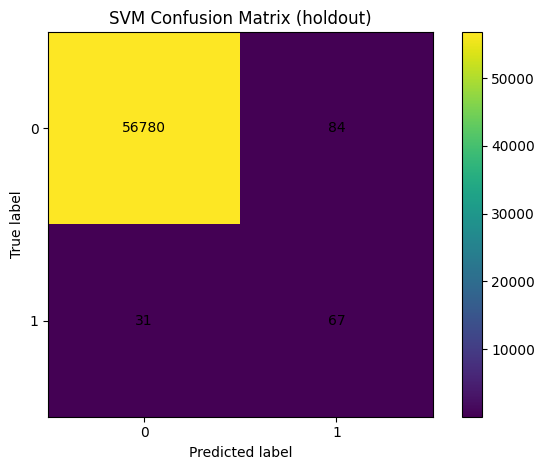

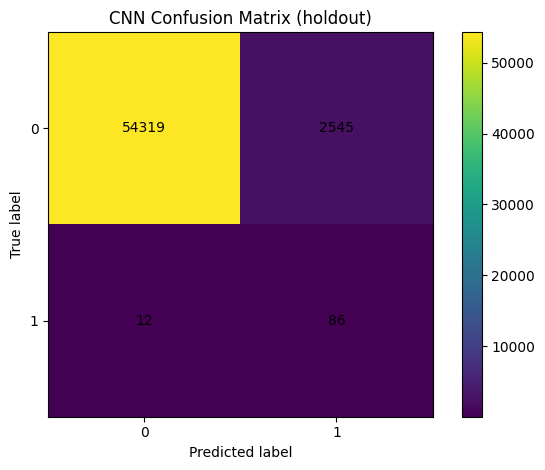

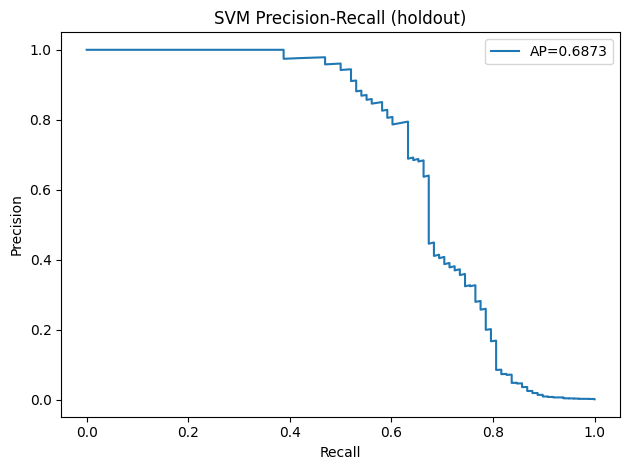

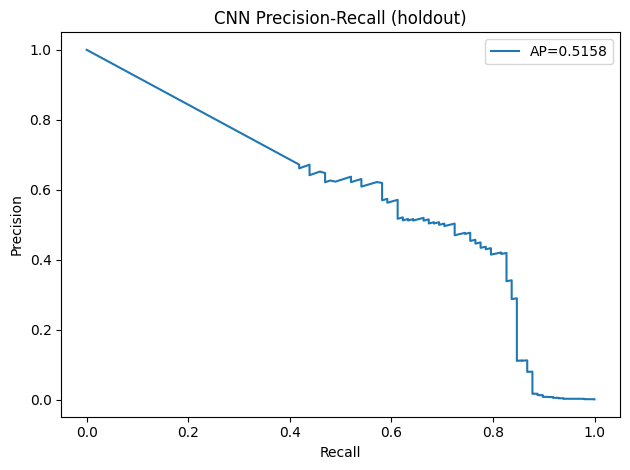

In [ ]:

X_raw = df.drop(columns=['Class']).values
y_raw = df['Class'].values
X_tr, X_te, y_tr, y_te = train_test_split(X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=RANDOM_STATE)

# SVM (best) on holdout
best_svm.fit(X_tr, y_tr)
svm_pred = best_svm.predict(X_te)

# CNN (best) on holdout
X_tr_k = X_tr.reshape((X_tr.shape[0], X_tr.shape[1], 1)).astype('float32')
X_te_k = X_te.reshape((X_te.shape[0], X_te.shape[1], 1)).astype('float32')
cnn_best = build_cnn(X_tr_k.shape[1],
                     filters=int(best_cnn_trial['filters']),
                     kernel_size=int(best_cnn_trial['kernel_size']),
                     dense=int(best_cnn_trial['dense']),
                     dropout=float(best_cnn_trial['dropout']))
cnn_best.fit(X_tr_k, y_tr, epochs=int(best_cnn_trial['epochs']), batch_size=int(best_cnn_trial['batch_size']),
             class_weight=K_CLASS_WEIGHT, verbose=0)
cnn_scores = cnn_best.predict(X_te_k, verbose=0).ravel()
cnn_pred = (cnn_scores >= 0.5).astype('int32')

# Confusion matrices
def plot_cm(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(2), yticks=np.arange(2),
           xticklabels=['0','1'], yticklabels=['0','1'],
           ylabel='True label', xlabel='Predicted label', title=title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=150)
    plt.show()

plot_cm(y_te, svm_pred, "SVM Confusion Matrix (holdout)", "svm_cm_holdout.png")
plot_cm(y_te, cnn_pred, "CNN Confusion Matrix (holdout)", "cnn_cm_holdout.png")

# PR curves
def plot_pr(y_true, scores, title, fname):
    prec, rec, _ = precision_recall_curve(y_true, scores, pos_label=1)
    ap = average_precision_score(y_true, scores, pos_label=1)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=150)
    plt.show()


try:
    svm_scores = best_svm.decision_function(X_te)
except Exception:
    svm_scores = best_svm.predict(X_te)

plot_pr(y_te, svm_scores, "SVM Precision-Recall (holdout)", "svm_pr_holdout.png")
plot_pr(y_te, cnn_scores, "CNN Precision-Recall (holdout)", "cnn_pr_holdout.png")



## References (APA 7th)
- Kaggle DATASET - https://www.kaggle.com/code/jaiswal12345/starter-credit-card-fraud-detection-2145d174-e/input
- Hajek, P., Abedin, M. Z., & Sivarajah, U. (2022). Fraud detection in mobile payment systems using an XGBoost-based framework. *Information Systems Frontiers*, 1–19.
- Machine Learning Group – ULB. (n.d.). *Credit Card Fraud Detection*. https://www.kaggle.com/mlg-ulb/creditcardfraud/ (Accessed 2024-02-04)
- Pozzolo, A. D., Caelen, O., Johnson, R. A., & Bontempi, G. (2015). Calibrating probability with undersampling for unbalanced classification. In *2015 IEEE Symposium Series on Computational Intelligence* (pp. 159–166). https://doi.org/10.1109/SSCI.2015.33
- Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830. https://scikit-learn.org/stable/model_selection.html
- Velarde, G., Weichert, M., Deshmunkh, A., Deshmane, S., Sudhir, A., Sharma, K., & Joshi, V. (2024). Tree boosting methods for balanced and imbalanced classification and their robustness over time in risk assessment. *Intelligent Systems with Applications*, 200354. https://doi.org/10.1016/j.iswa.2024.200354
